In [1]:
# import required packages
import pandas as pd
import numpy as np
import math

# advanced statistics library
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.colors as colors

# SEE COMMENTS ABOUT PYSHEDS LIBRARY IN NEXT CELL
from pysheds.grid import Grid
import warnings
warnings.filterwarnings('ignore')

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, LogTicker, ColorBar, BasicTickFormatter
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
def slope(x,y):

    print('')
    
    grid = Grid.from_ascii(path='../../data/notebook_5_data/n49w1235_con_grid.asc', 
                       data_name='dem')
    
    grid.nodata = 0
    
    map_extents = grid.extent
    min_x, max_x, min_y, max_y = map_extents
    
    tools = "pan,wheel_zoom,box_zoom,reset,tap"

    # show the precision of the decimal coordinates
    # in the plot to 5 decimal places
    TOOLTIPS = [
        ("(x,y)", "($x{1.11111}, $y{1.11111})"),]

    # create a figure, setting the x and y ranges to the appropriate data bounds
    p1 = figure(title="DEM of the Lower Mainland of BC.  Hover to get coordintes.", plot_width=600, plot_height=int(400),
                x_range = map_extents[:2], y_range = map_extents[2:], 
                tools=tools, tooltips=TOOLTIPS)

    # map elevation to a colour spectrum
    color_mapper = LinearColorMapper(palette="Magma256", low=-200, high=2400)

    # np.flipud flips the image data on a vertical axis
    adjusted_img = [np.flipud(grid.dem)]  

    p1.image(image=adjusted_img,   
             x=[min_x],               # lower left x coord
             y=[min_y],               # lower left y coord
             dw=[max_x-min_x],        # *data space* width of image
             dh=[max_y-min_y],        # *data space* height of image
             color_mapper=color_mapper)

    color_bar = ColorBar(color_mapper=color_mapper, #ticker=Ticker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

    p1.add_layout(color_bar, 'right')

    grid.resolve_flats('dem', out_name='inflated_dem')
    
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
    
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    
    grid.clip_to('dem')
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
                   recursionlimit=15000, xytype='label', nodata_out=0)
    
    grid.clip_to('catch', pad=(0,0,0,0))
    
    catch = grid.view('catch', nodata=np.nan)
    
    print('The shape of the catchment is:',catch.shape,'. Use this to check if the input coordinates are correct.')
    
    ext_1 = grid.extent
    
    grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')
    
    grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist', xytype='label', nodata_out=np.nan)
    
    #FUNCTION HERE FOR DISTANCES OF ONE DEGREE LAT AND LONG
    
    #from cell above:
    #           N    NE    E    SE    S    SW    W    NW
    # dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

    # degree of latitute = 111218.55 m
    # degree of longitude = 72499.36 m 
    
    #grid affine 0 = length of one cell in degrees of long and grid affine 4 = length of one cell of lat 

    len_x = grid._affine[0]*72499.36 #length of one cell of longitude in graph in m (x axis)

    len_y = grid._affine[4]*(-111218.55) #length of one cell of latitude in graph in m (y axis)

    len_diag = (len_x**2 + len_y**2)**0.5

    dir = grid.view('dir', nodata=np.nan)

    weights = (np.where((dir==64), len_y, 0) + np.where((dir==128), len_diag, 0) + 
               np.where((dir==1), len_x, 0) + np.where((dir==2), len_diag, 0) + 
               np.where((dir==4), len_y, 0) + np.where((dir==8), len_diag, 0) + 
               np.where((dir==16), len_x, 0) + np.where((dir==32), len_diag, 0)).ravel()
    
    grid.flow_distance(data='catch', x=x, y=y, weights=weights, dirmap=dirmap, out_name='dist2',
                   xytype='label', nodata_out=np.nan)
    
    grid.clip_to('catch')

    dem_small = grid.view('inflated_dem')

    dem_small[dem_small<0] = np.nan #make any non negative values a nan
    
    dem_small[dem_small>0].min() #finding elevation of intake (min of the catchment)

    height_above_outlet = dem_small - dem_small[dem_small>0].min() #finding elevation difference

    slope = height_above_outlet / grid.dist2 #grid of slope in m/m
    
    print('')
    
    # Plot the catchment
    fig, ax = plt.subplots(figsize=(10,9))
    fig.patch.set_alpha(0)

    plt.grid('on', zorder=0)

    im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
    plt.colorbar(im, ax=ax, values=sorted(dirmap), label='Flow Direction')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Delineated Catchment')
    
    fig, ax = plt.subplots(figsize=(10,9))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(slope, extent=grid.extent, zorder=2,
                   cmap='cubehelix_r')
    plt.colorbar(im, ax=ax, label='slope (m/m)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Slope')
    
    print('THE FOLLOWING ARE CHARACTERISTICS OF THE CATCHMENT:')
    print('')
    print('Average slope of catchment is:',np.nanmean(slope)*1000,'m/km')
    print('')
    print('The mean elevation of the catchment is:',np.nanmean(dem_small),'m')
    print('')
    print('The steepest slope in the catchment is:',np.nanmax(slope)*1000,'m/km')
    print('')
    print('The longest flow distance in the catchment is:',np.nanmax(grid.dist2),'m')
    print('')

    print('The following maps show the catchment, and the different slopes in the catchment:')


## USE FUNCTION HERE

MAGNESIA CHARACTERISTICS

The shape of the catchment is: (26, 57) . Use this to check if the input coordinates are correct.

THE FOLLOWING ARE CHARACTERISTICS OF THE CATCHMENT:

Average slope of catchment is: 362.1431657625372 m/km

The mean elevation of the catchment is: 1052.2228989037758 m

The steepest slope in the catchment is: 488.2801725995926 m/km

The longest flow distance in the catchment is: 4126.387913870596 m

The following maps show the catchment, and the different slopes in the catchment:



HARVEY CHARACTERISTICS

The shape of the catchment is: (37, 53) . Use this to check if the input coordinates are correct.

THE FOLLOWING ARE CHARACTERISTICS OF THE CATCHMENT:

Average slope of catchment is: 324.3133448809133 m/km

The mean elevation of the catchment is: 1059.5763575042158 m

The steepest slope in the catchment is: 588.9986741713974 m/km

The longest flow distance in the catchment is: 4185.314652460284 m

The following maps show the catchment, and the different slopes

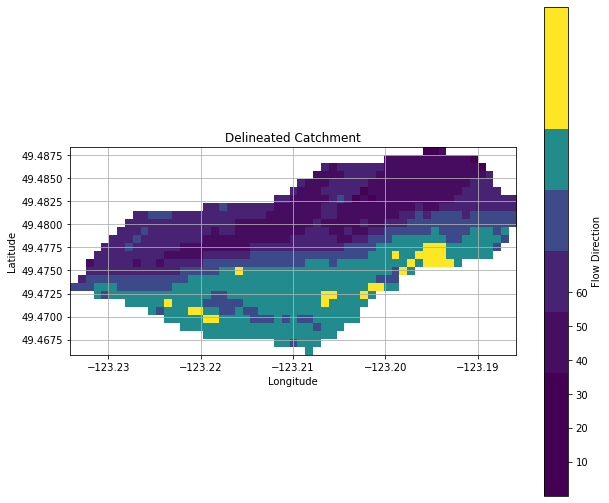

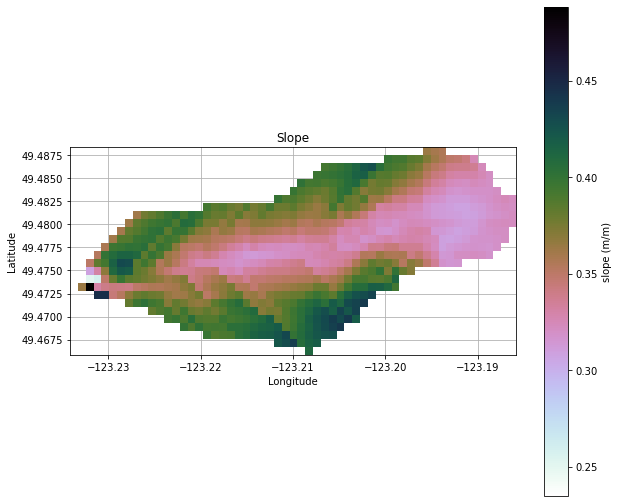

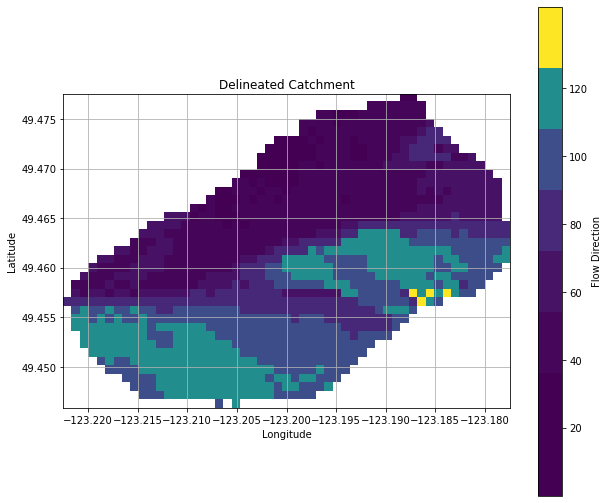

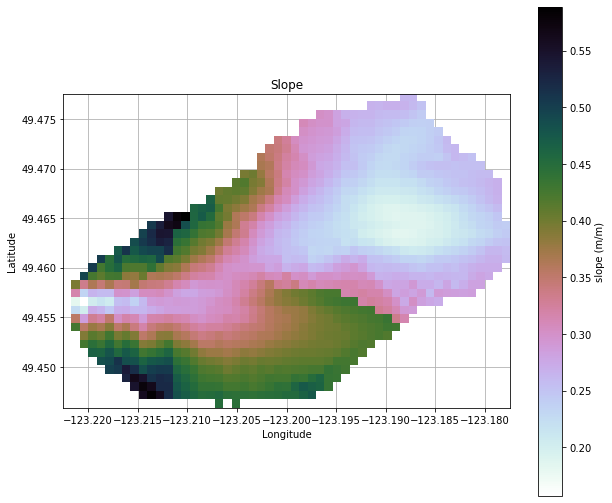

In [3]:
print('MAGNESIA CHARACTERISTICS')
slope(-123.23388889,49.47396389) #Magnesia Creek
print('')
print('')
print('')
print('HARVEY CHARACTERISTICS')
slope(-123.222197,49.457422) #Harvey Creek